Importing all libraries required for loading Dataset, ML Moedls, Ploting Graphs.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Loading the un-processed dataset. We can see that the Diabetes_Status column has textual values.

In [25]:
# === Load dataset ===
filename =  r"C:/Users/kbsao/Desktop/Machine Learning (MLE)/Project/diabetes_prediction_india (1).csv" 
data = pd.read_csv(filename)
print(f"Loaded dataset: {filename}")
print(f"Shape: {data.shape}\n")
print("Before preprocessing:\n", data["Diabetes_Status"].head())

Loaded dataset: C:/Users/kbsao/Desktop/Machine Learning (MLE)/Project/diabetes_prediction_india (1).csv
Shape: (5292, 27)

Before preprocessing:
 0    Yes
1     No
2    Yes
3     No
4    Yes
Name: Diabetes_Status, dtype: object


We first check if the Diabetes_Status column contains text labels and converts them to numeric values — 1 for diabetic and 0 for non-diabetic. It then separates the dataset into features (X) and the target variable (y). After that, all categorical columns in X are one-hot encoded to convert them into numeric form, with one category dropped to prevent redundancy. Finally, it prints the total number of features and the distribution of diabetic vs. non-diabetic samples.

In [26]:
if data["Diabetes_Status"].dtype == object:
    data["Diabetes_Status"] = (
        data["Diabetes_Status"]
        .replace({'Yes': 1, 'No': 0, 'Positive': 1, 'Negative': 0})
        .astype(int)
    )
target_col = "Diabetes_Status"
X = data.drop(columns=[target_col])
y = data[target_col]

# === One-hot encode categorical features ===
X = pd.get_dummies(X, drop_first=True)
print(f"One-hot encoded features: {X.shape[1]} total\n")
print("Target distribution:\n", y.value_counts())


One-hot encoded features: 32 total

Target distribution:
 Diabetes_Status
1    2704
0    2588
Name: count, dtype: int64


C:\Users\kbsao\AppData\Local\Temp\ipykernel_6784\616506442.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'Yes': 1, 'No': 0, 'Positive': 1, 'Negative': 0})


Here, we first split our dataset into training and testing sets, keeping 20% of the data for testing while making sure both sets have a similar class distribution using stratified sampling. Next, we apply feature scaling with StandardScaler, which standardizes all features to have a mean of zero and a standard deviation of one. The scaler is fit on the training data and then used to transform both the training and test sets for consistency.

In [27]:
# === Split and scale ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In this part, we define a set of machine learning models along with their corresponding hyperparameter grids. Each entry in the dictionary pairs a model, like Logistic Regression, K-Nearest Neighbors, SVM, Random Forest, or Gradient Boosting, with a set of parameters that will be tuned during training. These parameter grids specify different values the model will test—such as the number of neighbors in KNN or the learning rate in Gradient Boosting—to find the best-performing configuration.

In [28]:
# === Define models and parameter grids ===
param_grids = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "liblinear"]}
    ),
    "K-Nearest Neighbors": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    ),
    "Support Vector Machine": (
        SVC(probability=True),
        {"C": [0.1, 1, 10], "gamma": ["scale", "auto"], "kernel": ["rbf", "poly", "sigmoid"]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {"n_estimators": [100, 200],
         "max_depth": [None, 10, 20],
         "min_samples_split": [2, 5],
         "min_samples_leaf": [1, 2]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {"n_estimators": [100, 200],
         "learning_rate": [0.05, 0.1, 0.2],
         "max_depth": [3, 4, 5]}
    )
}

In this section, we perform model training and hyperparameter tuning for each algorithm defined earlier. Using GridSearchCV, each model is trained with different parameter combinations through 5-fold cross-validation to find the best set of parameters that maximize accuracy. Once the best model is found, it’s tested on the scaled test set to predict outcomes. The performance metrics—accuracy, precision, recall, and F1 score—are then calculated and stored. Finally, we print a summary comparing how each tuned model performed.

In [29]:
# === Train + tune models ===
results = {}

for name, (model, grid) in param_grids.items():
    print(f"\n Tuning {name}...")
    search = GridSearchCV(model, grid, cv=5, scoring="accuracy", n_jobs=-1)
    search.fit(X_train_scaled, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    results[name] = {
        "Model": best_model,
        "Best Params": search.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

# === Display summary ===
print("\n Final Model Performance Summary:\n")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Best Params : {metrics['Best Params']}")
    print(f"  Accuracy    : {metrics['Accuracy']:.4f}")
    print(f"  Precision   : {metrics['Precision']:.4f}")
    print(f"  Recall      : {metrics['Recall']:.4f}")
    print(f"  F1 Score    : {metrics['F1 Score']:.4f}")
    print("-" * 60)


 Tuning Logistic Regression...


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

Here, we compare all the trained models based on their accuracy scores and select the one with the highest value. The corresponding model and its performance metrics are then extracted, and the best model’s name along with its accuracy is printed as the final result.

In [ ]:
# === Identify best model ===
best_model_name, best_metrics = max(results.items(), key=lambda x: x[1]["Accuracy"])
best_model = best_metrics["Model"]
print(f"\n Best Model: {best_model_name} with Accuracy = {best_metrics['Accuracy']:.4f}")


 Best Model: Support Vector Machine with Accuracy = 0.5109


In this part, we use the best-performing model to predict diabetes outcomes on the test data and generate a confusion matrix to visualize its performance. The heatmap shows how many predictions were correct or incorrect, with true labels on the y-axis and predicted labels on the x-axis. This helps us see where the model is making errors, such as false positives or false negatives.

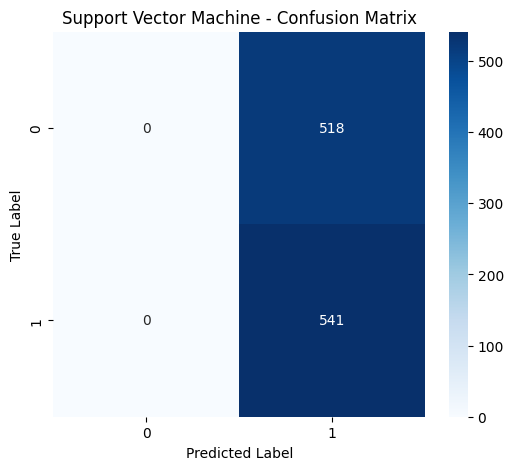

In [ ]:
# === Confusion Matrix ===
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{best_model_name} - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Here, we evaluate how well the best model distinguishes between diabetic and non-diabetic cases using the ROC-AUC curve. If the model supports probability predictions, we use them directly; otherwise, we calibrate the model to obtain them. The false positive rate and true positive rate are computed to plot the ROC curve, and the Area Under the Curve (AUC) value summarizes the model’s classification performance — a higher AUC indicates better discrimination ability.

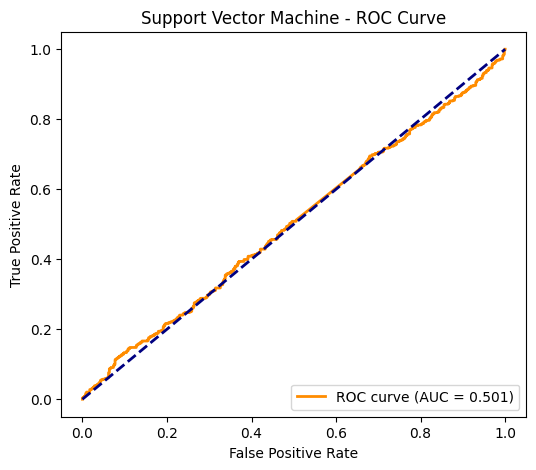

In [ ]:
# === ROC-AUC Curve ===
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    # for models like SVM without probability=True
    from sklearn.calibration import CalibratedClassifierCV
    calibrated = CalibratedClassifierCV(best_model, cv=5)
    calibrated.fit(X_train_scaled, y_train)
    y_proba = calibrated.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{best_model_name} - ROC Curve")
plt.legend(loc="lower right")
plt.show()

As we can see from the accuracy and the confusion matrix, the best performing model, ie SVM is only getting a 51% accuracy, essentally no better than a coin toss or just guessing. This lead us to believe there was an issue with the dataset. After going through the dataset, we realised that some of the data entries did not make sense from a biological standpoint. These inconsistencies are discussed below.

Specifically, we look for cases where both fasting blood sugar is below 99 mg/dL and postprandial blood sugar is below 140 mg/dL — values that usually indicate normal glucose levels — but the record is still labeled as diabetic (Diabetes_Status = 1). The code prints how many such cases exist and displays the first few examples for inspection.

In [ ]:
print("Checking for inconsistencies...\n")

# Fasting blood sugar < 99 but labeled diabetic
low_fbs_pbs_diabetic = data[(data["Fasting_Blood_Sugar"] < 99) &(data["Postprandial_Blood_Sugar"] < 140) & (data["Diabetes_Status"] == 1)]
print(f" FBS < 99, PBS < 140 but Diabetes_Status = 1 → {len(low_fbs_pbs_diabetic)} cases")
print(
    low_fbs_pbs_diabetic[["Fasting_Blood_Sugar", "Postprandial_Blood_Sugar", "Diabetes_Status"]]
    .head(5),
    "\n")

Checking for inconsistencies...

 FBS < 99, PBS < 140 but Diabetes_Status = 1 → 251 cases
     Fasting_Blood_Sugar  Postprandial_Blood_Sugar  Diabetes_Status
10                  91.3                     138.3                1
21                  76.7                      92.8                1
23                  92.8                     128.9                1
208                 90.5                      99.1                1
232                 84.0                      93.2                1 



In this section, we check for cases where the HbA1c value is greater than 6.5%—a level typically diagnostic of diabetes—but the record is labeled as non-diabetic (Diabetes_Status = 0). The code counts how many such inconsistencies exist and prints the first few examples to help verify if the labeling might be incorrect.

In [ ]:
# HBA1C > 6.5 but labeled non-diabetic
high_hba1c_nondiabetic = data[(data["HBA1C"] > 6.5) & (data["Diabetes_Status"] == 0)]
print(f"HBA1C > 6.5 but Diabetes_Status = 0 → {len(high_hba1c_nondiabetic)} cases")
print(high_hba1c_nondiabetic[["HBA1C","Diabetes_Status"]].head(5), "\n")

HBA1C > 6.5 but Diabetes_Status = 0 → 1881 cases
    HBA1C  Diabetes_Status
3    11.9                0
6     7.6                0
7     9.2                0
8     8.7                0
19    8.6                0 



Here, we combine the indices of all inconsistent entries—those with mismatched blood sugar or HbA1c values—and remove them from the dataset. The cleaned dataset is then reset with a fresh index, and the code prints how many inconsistent rows were removed along with the new shape of the dataset.

In [ ]:
# === Drop inconsistent rows ===
inconsistent_indices = pd.concat([low_fbs_pbs_diabetic, high_hba1c_nondiabetic]).index
cleaned_data = data.drop(index=inconsistent_indices).reset_index(drop=True)
print(f"\n Removed {len(inconsistent_indices)} inconsistent entries")
print(f"Cleaned dataset shape: {cleaned_data.shape}")


 Removed 2132 inconsistent entries
Cleaned dataset shape: (3160, 27)


In this final step, the cleaned dataset—after removing inconsistent entries—is saved as a new CSV file at the specified location. The index=False ensures that row indices aren’t included in the file, and a confirmation message is printed showing where the cleaned data has been stored.

In [ ]:
output_filename = r"C:/Users/kbsao/Desktop/Machine Learning (MLE)/Project/diabetes_without_inconsistencies.csv"
cleaned_data.to_csv(output_filename, index=False)
print(f" Cleaned dataset saved as '{output_filename}'")

 Cleaned dataset saved as 'C:/Users/kbsao/Desktop/Machine Learning (MLE)/Project/diabetes_without_inconsistencies.csv'


Loading the new cleaned dataset for final prediction to check if accuracy has improved.

In [ ]:
# === Load dataset ===
filename =  r"C:/Users/kbsao/Desktop/Machine Learning (MLE)/Project/diabetes_without_inconsistencies.csv"
data = pd.read_csv(filename)
print(f"Loaded dataset: {filename}")
print(f"Shape: {data.shape}\n")

Loaded dataset: C:/Users/kbsao/Desktop/Machine Learning (MLE)/Project/diabetes_without_inconsistencies.csv
Shape: (3160, 27)



Here again we're checking if Diabetes_Status contains any text values and if does we're encoding them as 1 or 0 based on diabetic or non diabetic respectively. After that, the dataset is split into features (X) and the target variable (y). Finally, all categorical columns in X are one-hot encoded so that they can be represented numerically for model training, and the total number of resulting features is displayed.

In [ ]:
# === Ensure target column is numeric (1 = Yes, 0 = No) ===
if data["Diabetes_Status"].dtype == object:
    data["Diabetes_Status"] = (
        data["Diabetes_Status"]
        .replace({'Yes': 1, 'No': 0, 'Positive': 1, 'Negative': 0})
        .astype(int)
    )

target_col = "Diabetes_Status"
X = data.drop(columns=[target_col])
y = data[target_col]

# === One-hot encode categorical features ===
X = pd.get_dummies(X, drop_first=True)
print(f"One-hot encoded features: {X.shape[1]} total\n")


One-hot encoded features: 32 total



Here, we first split our dataset into training and testing sets, keeping 20% of the data for testing while making sure both sets have a similar class distribution using stratified sampling. Next, we apply feature scaling with StandardScaler, which standardizes all features to have a mean of zero and a standard deviation of one. The scaler is fit on the training data and then used to transform both the training and test sets for consistency.

In [ ]:
# === Split and scale ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Similar to the step above we're defining a set of machine learning models with their hyperparameter grids.

In [ ]:
# === Define models and parameter grids ===
param_grids = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "liblinear"]}
    ),
    "K-Nearest Neighbors": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    ),
    "Support Vector Machine": (
        SVC(probability=True),
        {"C": [0.1, 1, 10], "gamma": ["scale", "auto"], "kernel": ["rbf", "poly", "sigmoid"]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {"n_estimators": [100, 200],
         "max_depth": [None, 10, 20],
         "min_samples_split": [2, 5],
         "min_samples_leaf": [1, 2]}
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=42),
        {"n_estimators": [100, 200],
         "learning_rate": [0.05, 0.1, 0.2],
         "max_depth": [3, 4, 5]}
    )
}

Now model traning and hyperparameter tuning is performed again for the new dataset. The pipeline is similar to the previous dataset.

In [ ]:
# === Train + tune models ===
results = {}

for name, (model, grid) in param_grids.items():
    print(f"\n Tuning {name}...")
    search = GridSearchCV(model, grid, cv=5, scoring="accuracy", n_jobs=-1)
    search.fit(X_train_scaled, y_train)
    
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    results[name] = {
        "Model": best_model,
        "Best Params": search.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

# === Display summary ===
print("\n Final Model Performance Summary:\n")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Best Params : {metrics['Best Params']}")
    print(f"  Accuracy    : {metrics['Accuracy']:.4f}")
    print(f"  Precision   : {metrics['Precision']:.4f}")
    print(f"  Recall      : {metrics['Recall']:.4f}")
    print(f"  F1 Score    : {metrics['F1 Score']:.4f}")
    print("-" * 60)


 Tuning Logistic Regression...

 Tuning K-Nearest Neighbors...

 Tuning Support Vector Machine...

 Tuning Random Forest...

 Tuning Gradient Boosting...

 Final Model Performance Summary:

Logistic Regression:
  Best Params : {'C': 0.01, 'solver': 'lbfgs'}
  Accuracy    : 0.7658
  Precision   : 0.7835
  Recall      : 0.9654
  F1 Score    : 0.8650
------------------------------------------------------------
K-Nearest Neighbors:
  Best Params : {'n_neighbors': 9, 'weights': 'distance'}
  Accuracy    : 0.7816
  Precision   : 0.7927
  Recall      : 0.9735
  F1 Score    : 0.8739
------------------------------------------------------------
Support Vector Machine:
  Best Params : {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
  Accuracy    : 0.7769
  Precision   : 0.7769
  Recall      : 1.0000
  F1 Score    : 0.8744
------------------------------------------------------------
Random Forest:
  Best Params : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# === Identify best model ===
best_model_name, best_metrics = max(results.items(), key=lambda x: x[1]["Accuracy"])
best_model = best_metrics["Model"]
print(f"\n Best Model: {best_model_name} with Accuracy = {best_metrics['Accuracy']:.4f}")


 Best Model: Random Forest with Accuracy = 0.8038


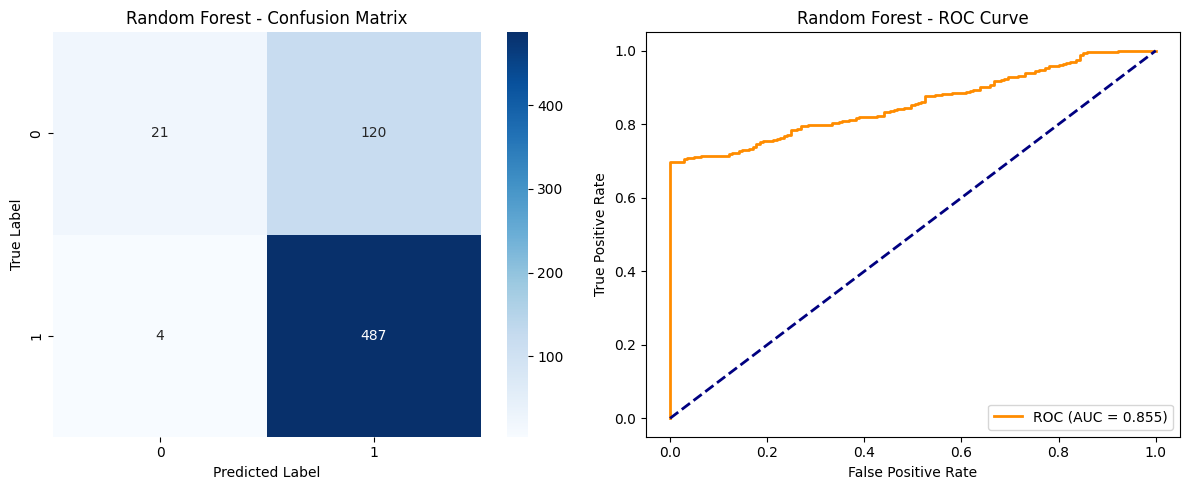

In [ ]:
# === Predictions ===
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

# === ROC-AUC Curve data ===
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    from sklearn.calibration import CalibratedClassifierCV
    calibrated = CalibratedClassifierCV(best_model, cv=5)
    calibrated.fit(X_train_scaled, y_train)
    y_proba = calibrated.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# === Create side-by-side plots ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# --- Confusion Matrix ---
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f"{best_model_name} - Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# --- ROC Curve ---
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_title(f"{best_model_name} - ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()



As we can see removing inconsistent data from the dataset has greatly improved our accuracy. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import shap

# 1. Load Dataset
df = pd.read_csv('diabetes_without_inconsistencies.csv')

# 2. Cleaning & Preprocessing
# Issue A: 'Alcohol_Intake' has NaNs. We treat them as 'None'.
df['Alcohol_Intake'] = df['Alcohol_Intake'].fillna('None')

# Issue B: 'Polycystic_Ovary_Syndrome' has '0' (for Males/Others) and 'No' (for Females).
# We merge '0' into 'No' to make the user interface cleaner.
df['Polycystic_Ovary_Syndrome'] = df['Polycystic_Ovary_Syndrome'].replace('0', 'No')

# 3. Define Features and Target
X = df.drop(columns=['Diabetes_Status'])
y = df['Diabetes_Status']

# 4. One-Hot Encoding
# We use pd.get_dummies to turn text categories into numbers
X_encoded = pd.get_dummies(X)

# 5. Handle Class Imbalance
# (The dataset might be imbalanced, SMOTE helps the model learn minority classes)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 6. Train Model
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print(f"Model trained. Accuracy: {model.score(X_test, y_test):.2f}")

# 7. Generate SHAP Explainer
print("Generating SHAP explainer...")
explainer = shap.TreeExplainer(model)

# 8. Save Artifacts
# We save the exact list of columns (features) so the app can recreate them perfectly
joblib.dump(model, 'diabetes_model_v2.pkl')
joblib.dump(X_encoded.columns.tolist(), 'model_features_v2.pkl')
joblib.dump(explainer, 'shap_explainer_v2.pkl')

print("Success! Files saved: diabetes_model_v2.pkl, model_features_v2.pkl, shap_explainer_v2.pkl")

c:\Users\kbsao\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model trained. Accuracy: 0.88
Generating SHAP explainer...
Success! Files saved: diabetes_model_v2.pkl, model_features_v2.pkl, shap_explainer_v2.pkl


Model loaded successfully.


C:\Users\kbsao\AppData\Local\Temp\ipykernel_37072\2520134262.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


Feature importance chart saved as: feature_importance_chart.png


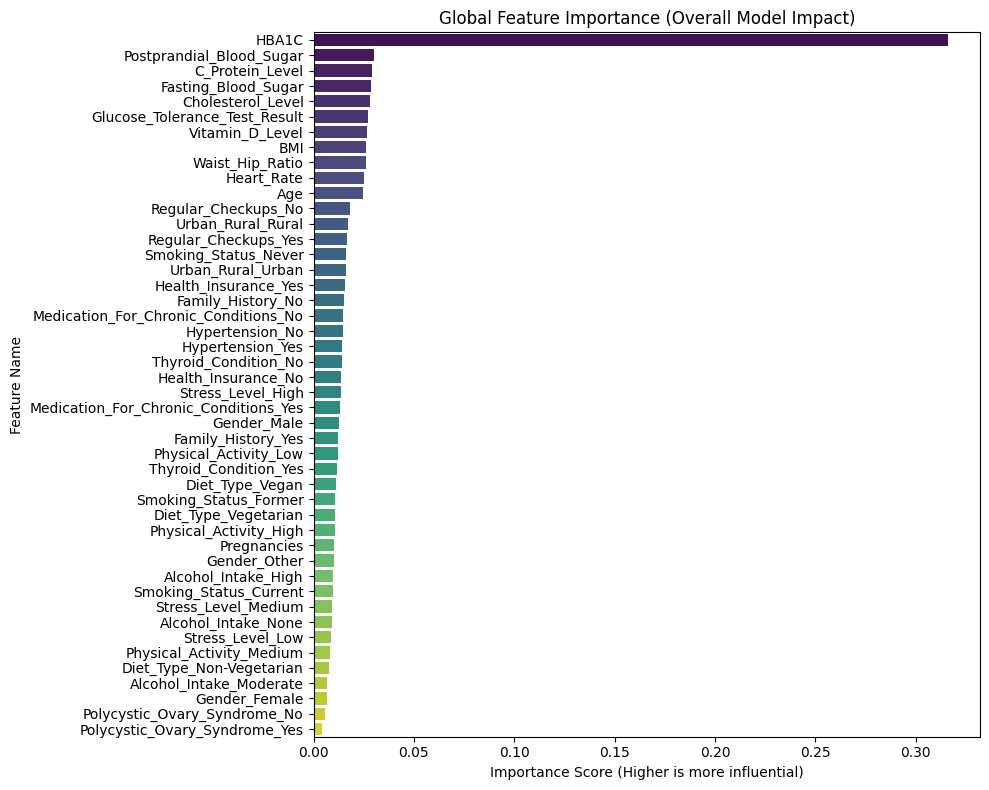

In [2]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the trained model and feature names
try:
    model = joblib.load('diabetes_model_v2.pkl')
    features = joblib.load('model_features_v2.pkl')
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: Model files not found. Run train_model.py first.")
    exit()

# 2. Extract Feature Importance
# Random Forest models have a built-in attribute for this
importances = model.feature_importances_

# 3. Create a DataFrame for better handling
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# 4. Sort by importance (highest on top)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 5. Plotting
plt.figure(figsize=(10, 8))
# Use a color palette that highlights the top features
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.title('Global Feature Importance (Overall Model Impact)')
plt.xlabel('Importance Score (Higher is more influential)')
plt.ylabel('Feature Name')
plt.tight_layout()

# 6. Save the plot
output_file = 'feature_importance_chart.png'
plt.savefig(output_file)
print(f"Feature importance chart saved as: {output_file}")
plt.show()